# SUBMISSION FOR HACKATHON_1 GDSC

I have used and Implemented **DCGAN** for generating images of Alphabets <br/><br/> Considering the small size of the training dataset, **batchsize_size = 0** , **Epochs = 50**
<br/> Epochs could be increased for better results but as it was taking too long i have just shown results for 50 epochs


## IMPORTING LIBRARIES

Implementation is done using PyTorch. <br/> I have used the [Pytorch implementation](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) in their documentation for Refrence of some part of code with some relevant changes according to our dataset

In [1]:

import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data


In [2]:
import torchvision.datasets as dset

In [3]:
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


## LOADING DATASET AND DEFINING ALL HYPERPARAMETERS

Here first ive set a seed value so that code is uniform and can be reporduced <br/><br/>
To run the code on other system just change the *dataroot* variable <br/><br/>
The dataset is loaded using pytorch's dataset loader class ,  all hyperparameters values are taken from the DCGAN paper <br/><br/>
Since DCGAN is really sensitive to hyperparameters, it is not adviced to change them

In [4]:
randnum = 999

random.seed(randnum)
torch.manual_seed(randnum)
torch.use_deterministic_algorithms(True)

In [5]:
abs_path = os.path.abspath('train_images')

In [29]:
dataroot = r'C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_Dataset'

workers = 2

batch_size = 1

image_size = 64

nc = 3

nz = 100 

ngf = 64

ndf = 64

num_epochs = 50

lr = 0.0002

beta1 = 0.5



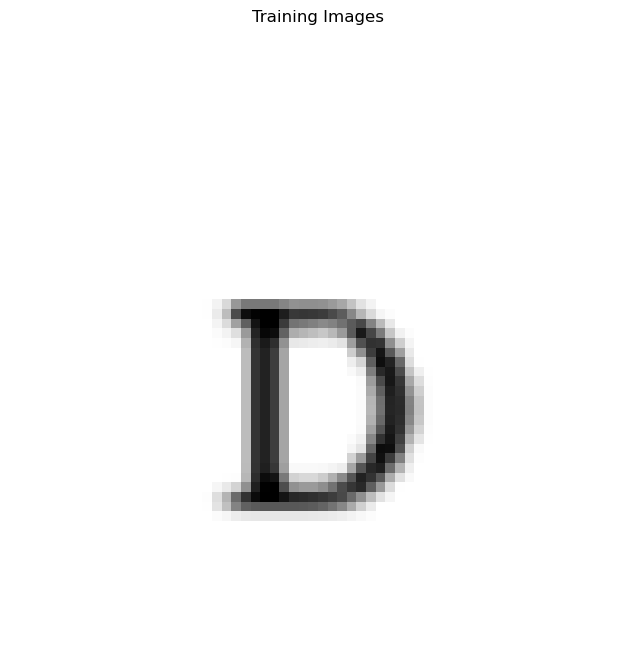

In [30]:
dataset = dset.ImageFolder(root = dataroot,
                           transform= transforms.Compose([
                               # Here i have added two lines of code since our dataset had images of 36*36 pixels
                               # We are resizing it to 64*64, as the original paper had images of 64*64 in it.
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
device = torch.device("cpu")
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

## DEFINING WEIGHTS AND CREATING GENERATOR AND DISCRIMINATOR CLASS

All model weights are randomly initialized with Normal distribution of *mean=0, stdev=0.02*, as mentioned in DCGAN's paper <br/>
Strides and Padding are set according to the DCGAN's Paper <br/><br/>
In the DCGAN paper initial convolution is of depth **1024** but i have used **512** 

In [31]:
def weights_init(m):
    #takes class name of m as input
    classname = m.__class__.__name__
    # if its a conv layer initialise weights accordingly
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0,0.02)
    # if its a batchnorm layer initialise weights accordingly    
    elif classname.find('BatchNorm')!= -1:
        nn.init.normal_(m.weight.data, 1.0,0.02)
        #bias terms are set to 0
        nn.init.constant_(m.bias.data,0)

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d(nz, ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # 512*4*4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 256*8*8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 128*16*16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 64*32*32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 3*64*64`
        )

    def forward(self, input):
        return self.main(input)
        

In [33]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64*32*32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 128*16*16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 256*8*8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 512*4*4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # Final output is a single integer on which sigmoid is applied
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [35]:
netD = Discriminator().to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


##  DEFINING LOSS FUNCTION AND TRAINING THE MODEL

As mentioned in paper, BCE is used for calculating loss <br/>

Our objective is to maximize **log(D(x)) + log(1- D(G(x)))** , first real images are pased through discriminator to maxmimize the value of log(D(x)) so that the model becomes really good in finding images which are real <br/>
<br/>
Generators's objective is to minimize **log(1- D(G(x)))** so that the discriminator rates the fake generated images as real only





In [36]:
#we will use binary cross entropy loss for updating the weights and calculating loss
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1,1, device = device)
real_label = 1
fake_label = 0
#update the weights of the discriminator during training
optimizerD = optim.Adam(netD.parameters(), lr=lr , betas=(beta1,0.999))
#update the weights of the generator during training
optimizerG = optim.Adam(netG.parameters(), lr= lr , betas=(beta1,0.999))



In [37]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1














Starting Training Loop...
[0/50][0/520]	Loss_D: 2.0273	Loss_G: 13.4647	D(x): 0.2024	D(G(z)): 0.3495 / 0.0000
[0/50][1/520]	Loss_D: 0.2897	Loss_G: 14.9199	D(x): 0.9918	D(G(z)): 0.2453 / 0.0000
[0/50][2/520]	Loss_D: 1.2544	Loss_G: 18.4944	D(x): 0.9916	D(G(z)): 0.7124 / 0.0000
[0/50][3/520]	Loss_D: 0.0184	Loss_G: 6.3293	D(x): 0.9999	D(G(z)): 0.0181 / 0.0018
[0/50][4/520]	Loss_D: 0.1353	Loss_G: 6.2218	D(x): 0.8826	D(G(z)): 0.0104 / 0.0020
[0/50][5/520]	Loss_D: 0.0318	Loss_G: 5.5620	D(x): 0.9833	D(G(z)): 0.0148 / 0.0038
[0/50][6/520]	Loss_D: 0.0255	Loss_G: 5.6901	D(x): 0.9979	D(G(z)): 0.0231 / 0.0034
[0/50][7/520]	Loss_D: 0.0185	Loss_G: 5.6723	D(x): 1.0000	D(G(z)): 0.0182 / 0.0034
[0/50][8/520]	Loss_D: 0.0211	Loss_G: 5.7784	D(x): 1.0000	D(G(z)): 0.0209 / 0.0031
[0/50][9/520]	Loss_D: 0.3516	Loss_G: 17.5838	D(x): 0.9994	D(G(z)): 0.2960 / 0.0000
[0/50][10/520]	Loss_D: 0.0507	Loss_G: 8.0606	D(x): 1.0000	D(G(z)): 0.0494 / 0.0003
[0/50][11/520]	Loss_D: 0.0257	Loss_G: 6.3853	D(x): 0.9904	D(G(z)): 

## FINAL RESULTS AND A LOSS GRAPH TO VISUALIZE LOSS OF G AND D WHILE TRAINING

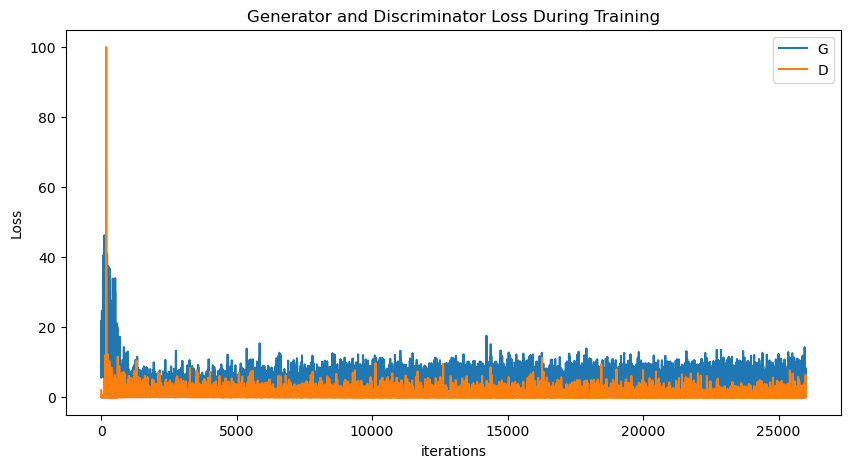

In [38]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

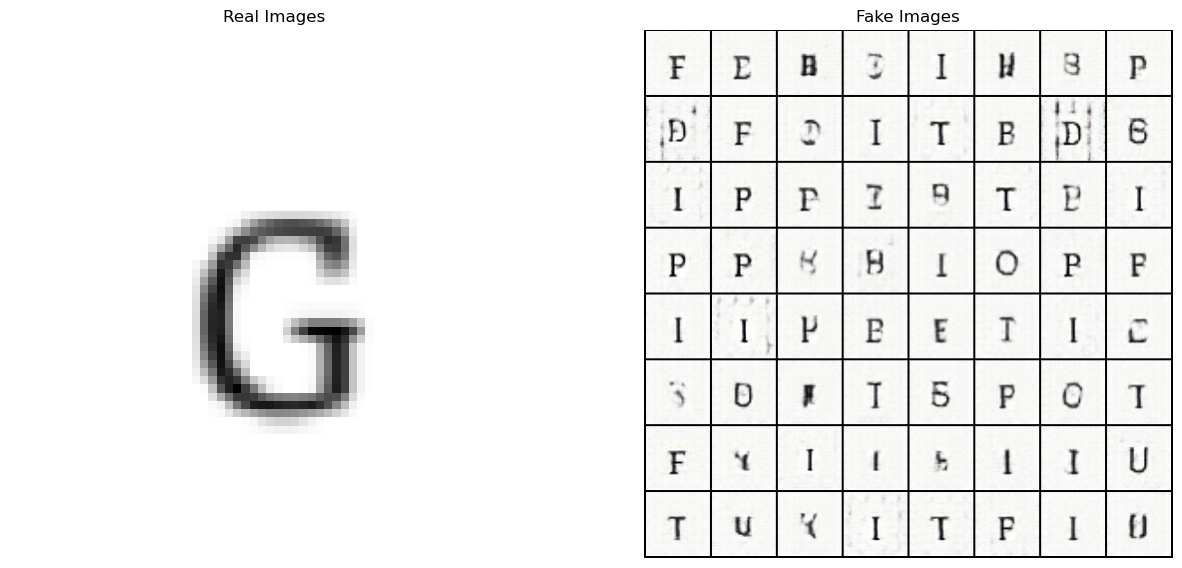

In [39]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()